In [3]:
!wget http://gsn.mimuw.edu.pl/DL1920-assignment3-data.zip
!mkdir -p data
!mv -f DL1920-assignment3-data.zip data/DL1920-assignment3-data.zip
!unzip data/DL1920-assignment3-data.zip -d data

--2020-05-26 19:39:18--  http://gsn.mimuw.edu.pl/DL1920-assignment3-data.zip
Resolving gsn.mimuw.edu.pl (gsn.mimuw.edu.pl)... 193.0.96.2, 2001:6a0:5001::3
Connecting to gsn.mimuw.edu.pl (gsn.mimuw.edu.pl)|193.0.96.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gsn.mimuw.edu.pl/DL1920-assignment3-data.zip [following]
--2020-05-26 19:39:18--  https://gsn.mimuw.edu.pl/DL1920-assignment3-data.zip
Connecting to gsn.mimuw.edu.pl (gsn.mimuw.edu.pl)|193.0.96.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45714 (45K) [application/zip]
Saving to: ‘DL1920-assignment3-data.zip’

DL1920-assignment3- 100%[===================>]  44,64K  --.-KB/s    in 0,01s   

2020-05-26 19:39:18 (4,23 MB/s) - ‘DL1920-assignment3-data.zip’ saved [45714/45714]

Archive:  data/DL1920-assignment3-data.zip
  inflating: data/test_y.csv         
  inflating: data/train_y.csv        
  inflating: data/test_x.csv         
  inflating: data/tra

In [57]:
import numpy as np
import pandas as pd

def parse_coords(coords):
    return [float(x) for x in coords.split('-')]

def get_x(filename):
    x_pd = pd.read_csv(filename, header=None)
    x_pd_parsed = x_pd.applymap(parse_coords)
    x_np = x_pd_parsed.to_numpy()
    return np.array([[x for x in y] for y in x_np[:]])

def get_y(filename):
    x_pd = pd.read_csv(filename, header=None)
    return x_pd.to_numpy()

In [124]:
X = get_x('data/train_x.csv')
y = get_y('data/train_y.csv').reshape((-1))

X_test = get_x('data/test_x.csv')
y_test = get_y('data/test_y.csv').reshape((-1))

In [125]:
y.shape

(9000,)

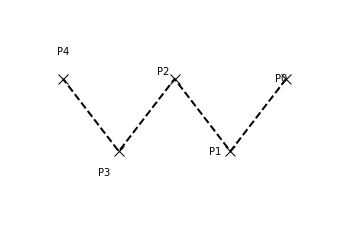

In [126]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches




def plot_path(verts, ax):
#     codes = [Path.CURVE4 for x in verts]
#     codes[0] = Path.MOVETO

#     path = Path(verts, codes)

#     patch = patches.PathPatch(path, facecolor='none', lw=2)
#     ax.add_patch(patch)
    ax.axis('off')
    
    xs, ys = zip(*verts)
    ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

    i=0
    for x,y in verts:
        rand_x,rand_y = np.random.rand(2)-0.5
        ax.text(x+rand_x, y+rand_y, 'P'+str(i))
        i += 1

    min_x,max_x = np.min(verts[:,0]),np.max(verts[:,0])
    min_y,max_y = np.min(verts[:,1]),np.max(verts[:,1])


    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)

fig, ax = plt.subplots()
plot_path(X[1], ax)
plt.show()

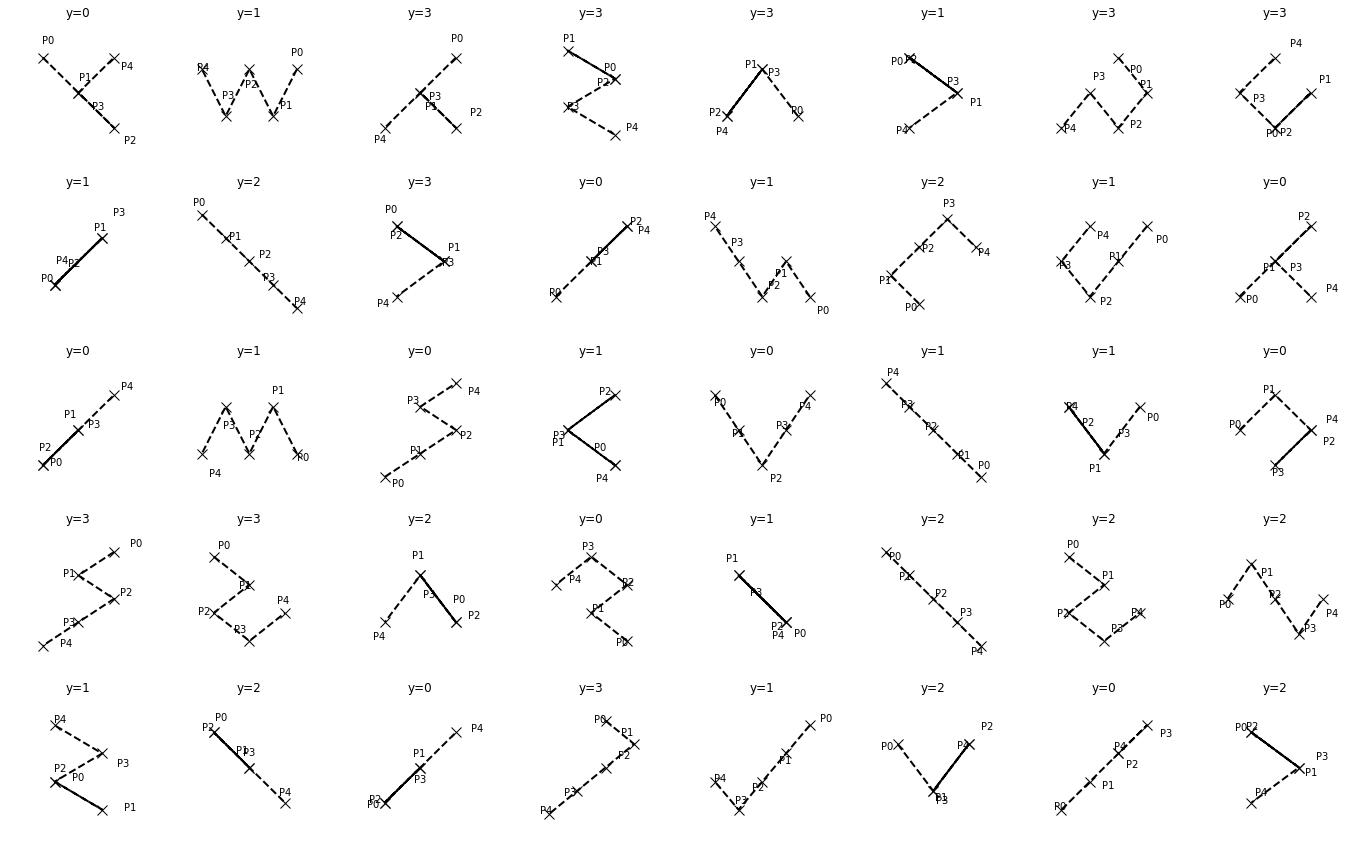

In [127]:
def plot_many(samples, labels=None):
    n = (samples.shape[0])
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 8
        rows = int((n+cols-1)/cols)
        fig = plt.figure(figsize=(cols * 3, rows * 3))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if labels is not None :
            sub.title.set_text('y={0}'.format(labels[i]))
        else :
            sub.title.set_text('nolabel')
        plot_path(samples[i], sub)

n = 40
plot_many(X[:n], y[:n])

In [128]:
flatX = X.reshape((X.shape[0], -1))

In [142]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=7)
clf.fit(flatX, y)
score = clf.score(X_test.reshape((X_test.shape[0], -1)), y_test)
score

0.676

# so much for training networks...

In [145]:
import torch.nn as nn
import torch

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = 2
n_categories = 4

rnn = RNN(n_letters, n_hidden, n_categories)



In [173]:
from torchvision.transforms.functional import to_tensor

Xt = to_tensor(X).float().permute(1,2,0)
inp = Xt[0][0:2]
hidden = torch.zeros(2, n_hidden)
print(inp.shape)
output, next_hidden = rnn(inp, hidden)
yt = torch.zeros(y.shape[0],4)
for i,idx in enumerate(y):
    yt[i,idx] = 1
yt[:5]
print(output.shape)

torch.Size([2, 2])
torch.Size([2, 4])


In [161]:
all_categories=['0', '1', '2', '3']
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('1', 1)


In [164]:
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [183]:
import time
import math

n_iters = X.shape[0]
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(n_iters):
    category = y[iter]
    line = X[iter].reshape(-1)
    category_tensor = torch.tensor([y[iter]], dtype=torch.long)
    line_tensor = Xt[iter].reshape(Xt[iter].shape[0],1,Xt[iter].shape[1])
#     print(line_tensor.shape)
#     print(category_tensor.shape)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess_i == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

0 0% (0m 0s) 1.0944 [7. 6. 8. 5. 9. 4. 8. 5. 9. 6.] / 2 ✗ (0)
500 5% (0m 0s) 0.7271 [1. 0. 0. 1. 1. 0. 2. 1. 3. 0.] / 2 ✓
1000 11% (0m 0s) 0.1915 [9. 6. 8. 5. 9. 6. 8. 7. 9. 8.] / 0 ✓
1500 16% (0m 1s) 0.1809 [2. 3. 1. 4. 0. 5. 1. 4. 0. 5.] / 1 ✓
2000 22% (0m 1s) 0.4235 [8. 8. 7. 7. 8. 8. 7. 9. 6. 8.] / 1 ✓
2500 27% (0m 1s) 0.2852 [7. 9. 6. 8. 5. 9. 4. 8. 3. 9.] / 1 ✓
3000 33% (0m 2s) 0.9268 [6. 8. 5. 9. 6. 8. 5. 7. 6. 6.] / 2 ✓
3500 38% (0m 2s) 1.8583 [5. 3. 4. 2. 5. 1. 4. 2. 3. 3.] / 3 ✗ (1)
4000 44% (0m 3s) 0.6808 [5. 0. 4. 1. 5. 2. 4. 1. 3. 0.] / 3 ✓
4500 50% (0m 3s) 0.6383 [9. 5. 8. 6. 7. 5. 8. 4. 9. 3.] / 2 ✓
5000 55% (0m 3s) 0.5016 [9. 2. 8. 1. 9. 0. 8. 1. 9. 2.] / 2 ✓
5500 61% (0m 4s) 0.5484 [9. 1. 8. 0. 7. 1. 6. 0. 5. 1.] / 3 ✓
6000 66% (0m 4s) 0.7039 [2. 2. 3. 1. 2. 2. 1. 3. 2. 4.] / 1 ✓
6500 72% (0m 4s) 0.5779 [4. 9. 3. 8. 4. 9. 5. 8. 6. 7.] / 0 ✓
7000 77% (0m 5s) 1.2043 [6. 9. 5. 8. 6. 9. 5. 8. 4. 9.] / 0 ✗ (1)
7500 83% (0m 5s) 0.1327 [2. 6. 3. 5. 4. 4. 5. 3. 4. 2.] / 2 ✓
80

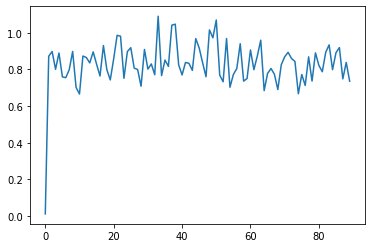

In [184]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [196]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


X_test_tens = to_tensor(X_test).float().permute(1,2,0)



def accuracy(testX, testY):
    sum_ok = 0
# Go through a bunch of examples and record which are correctly guessed
    for i in range(testX.shape[0]):
        category = testY[i]
        line = testX[i].reshape(-1)
        category_tensor = torch.tensor([testY[i]], dtype=torch.long)
        line_tensor = testX[i].reshape(testX[i].shape[0],1,testX[i].shape[1])

        output = evaluate(line_tensor)
        guess, guess_i = categoryFromOutput(output)
        if guess_i == category :
            sum_ok += 1
            
    acc = sum_ok/testX.shape[0]
    print('acc:', acc)
    return acc

In [197]:
accuracy(X_test_tens, y_test)
accuracy(Xt, y)

acc: 0.669
acc: 0.6862222222222222


0.6862222222222222